In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Swiss roll visualization:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=2048, noise=0.2, random_state=42)


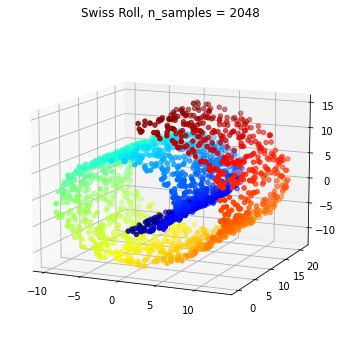

In [66]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.jet)#, s=50, alpha=0.8)
ax.view_init(azim=-66, elev=12)

ax.set_title("Swiss Roll, n_samples = %d"%2048)
plt.show()

In [ ]:
# Manually unroll the Swiss roll


# Apply MDS

In [4]:
def apply_MDS(D, k=2):
    # dimension of the distance matrix
    n = D.shape[0]

    I = np.eye(n)

    # column vector of ones of dim = (n,1)
    one = np.ones(n).reshape(-1,1)

    # operator
    H = I - (1./n)*np.dot(one, one.T)
    
    B = -0.5*np.matmul(H, np.matmul(D**2, H.T))

    # find evals, and eig vectors
    eig_vals, eig_vecs = np.linalg.eig(B)
    srt = np.argsort(eig_vals)[::-1] # indices of eigenvalues from largest to smallest
    eig_vals_srtd = eig_vals[srt] # sorted eigenvalues
    eig_vecs_srtd = eig_vecs[:, srt] # sorted eigenvectors

    # select first k largest evals and evectors
    Eval_2 = eig_vals_srtd[:k]
    Evec_2 = eig_vecs_srtd[:,:k]

    # coordinates of dimension, n x k
    X = np.matmul(Evec_2, np.diag(np.sqrt(Eval_2)))
    return X


In [33]:
# http://www.analytictech.com/networks/mds.htm
def compute_stress(D, X):
    
    from sklearn.metrics.pairwise import euclidean_distances
    dist = euclidean_distances(X)
    
    normalized_stress = np.sqrt( np.sum( (dist.ravel()-D.ravel())**2 ) / np.sum(dist**2)    )
    
    return normalized_stress
    

In [14]:
from sklearn.metrics.pairwise import euclidean_distances
D = euclidean_distances(X)
# Set the distances values to 8 decimals to avoid asymmetric 
D = np.around(D, decimals=8)
print("Is symmetric?", np.all(D==D.T))

Is symmetric? True


In [35]:
n_components = range(1,8)
stress_list = []

for k in n_components:
    X = apply_MDS(D, k=k)
    norm_stress = compute_stress(D, X)
    stress_list.append( norm_stress )

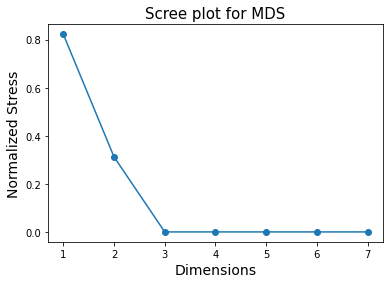

In [36]:
# Scree plot, stress versus number of components
plt.plot(n_components, stress_list, "o-")
plt.xlabel("Dimensions",size=14)
plt.ylabel("Normalized Stress", size=14)
plt.xticks(n_components, n_components)
plt.title("Scree plot for MDS", size=15)
plt.show()

# 2d plot


In [6]:
X_mds = apply_MDS(D, k=2)

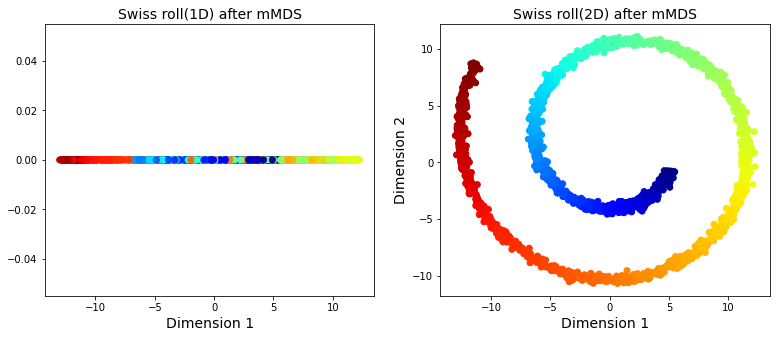

In [41]:
# the Swiss Roll, 2D 
fig = plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.scatter(X_mds[:, 0],np.zeros(X.shape[0]), c=t, cmap=plt.cm.jet)

plt.title('Swiss roll(1D) after mMDS', size=14)
plt.xlabel('Dimension 1', size=14)

plt.subplot(1,2,2)
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=t, cmap=plt.cm.jet)

plt.title('Swiss roll(2D) after mMDS', size=14)
plt.xlabel('Dimension 1', size=14)
plt.ylabel('Dimension 2', size=14)

plt.show()

# Performance evaluation

In [7]:
def centering_matrix(D):
    n = D.shape[0]

    I = np.eye(n)

    # column vector of ones of dim = (n,1)
    one = np.ones(n).reshape(-1,1)

    
    H = I - (1./n)*np.dot(one, one.T)
    
    B = -0.5*np.matmul(H, np.matmul(D**2, H.T))
    return B
    

In [106]:
def compute_graph_dist(X):
    
    from scipy.sparse.csgraph import dijkstra
    from sklearn.neighbors import kneighbors_graph
    
    D = kneighbors_graph(X, n_neighbors=15, mode="distance").toarray()
    
    Dijk_D = dijkstra(D, directed=False, indices=None, unweighted=False)
    
    return Dijk_D
    

In [110]:
def cost_function(X, X_reduced):
    
    from sklearn.metrics.pairwise import euclidean_distances
    # DY: Euclidean distance matrix in the embedded feature space
    DY = euclidean_distances(X_reduced) 
    DG = compute_graph_dist(X)
    
    # centering the two matrices
    tau_DG = centering_matrix(DG)
    tau_DY = centering_matrix(DY)
    
    # Compute L2 matrix norm or  the Frobenius norm
    n_samples = X_reduced.shape[0]
    
    E = np.linalg.norm(tau_DG-tau_DY, "fro")/n_samples
    
    return E
    
    

In [15]:
# performance analysis
n_comp = 10

X_mds = apply_MDS(D, k=n_comp)

gamma = 0.1
X_pc, eig_vals_srtd = gaussRBF_kernel_pca(X, gamma, n_comp)

k_opt = 20
isomap = Isomap(n_components=n_comp, n_neighbors=k_opt, path_method = "D", p=2)
X_reduced_isomap = isomap.fit_transform(X)



In [114]:
n_dimension = range(1,11)
error_mds = []
error_kpca = []
error_isomap = []

for i in n_dimension:
    error_mds.append( cost_function(X, X_mds[:,0:i]) )
    error_kpca.append( cost_function(X, X_pc[:,0:i]) )
    error_isomap.append(  cost_function(X, X_reduced_isomap[:,0:i]) )



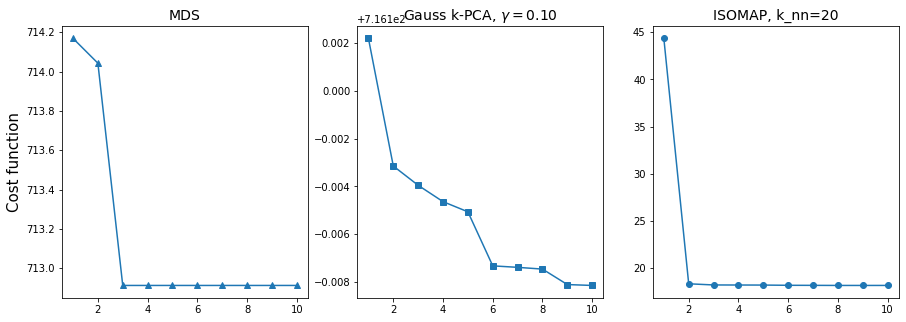

In [139]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(n_dimension, error_mds, marker='^')
#plt.yscale("log")
plt.title("MDS",size=14)
plt.ylabel("Cost function", size=15)



plt.subplot(1,3,2)

plt.plot(n_dimension, error_kpca, marker='s')
#plt.yscale("log")
plt.title("Gauss k-PCA, $\gamma=$%.2f"%gamma,size=14)

plt.subplot(1,3,3)
plt.plot(n_dimension, error_isomap, marker='o')
plt.title("ISOMAP, k_nn=%d"%k_opt,size=14)

plt.show()


# Residual Variance

In [52]:
# performance analysis
n_comp = 10

X_mds = apply_MDS(D, k=n_comp)

gamma = 0.1
X_pc, eig_vals_srtd = gaussRBF_kernel_pca(X, gamma, n_comp)

k_opt = 15
isomap = Isomap(n_components=n_comp, n_neighbors=k_opt, path_method = "D", p=2)
X_reduced_isomap = isomap.fit_transform(X)



In [31]:
# algorithms best estimate of the manifold
def compute_DM_kpca(X, gamma):
    from sklearn.metrics.pairwise import euclidean_distances
    
    mat_sq_dists = euclidean_distances(X, squared=True)
    
    # Compute the symmetric kernel matrix.    
    K = np.exp(-gamma * mat_sq_dists)
    
    # ref: https://www.cs.mcgill.ca/~dprecup/courses/ML/Lectures/ml-lecture13.pdf
    # Euclidean distance in kernel space btw points phi(xi) and phi(xj)
    # ||phi(xi)-phi(xj)|| = K(xi,xi) +K(xj,xj) - 2K(xi,xj)
    D = np.zeros((K.shape[0], K.shape[1]))
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):
            D[i,j] = K[i,i]+K[j,j]-2*K[i,j]
    
    return D

def compute_DM_mds(X):
    from sklearn.metrics.pairwise import euclidean_distances   
    D = euclidean_distances(X)
    # Set the distances values to 8 decimals to avoid asymmetric 
    D = np.around(D, decimals=4)
    return D

    
def compute_DM_isomap(X, n_neighbors):
    from scipy.sparse.csgraph import dijkstra
    from sklearn.neighbors import kneighbors_graph
    
    D = kneighbors_graph(X, n_neighbors=n_neighbors, mode="distance").toarray()
    
    Dijk_D = dijkstra(D, directed=False, indices=None, unweighted=False)
    
    Dijk_D = np.around(Dijk_D, decimals=4)
    return Dijk_D
    
    
def compute_DX(X):
    from sklearn.metrics.pairwise import euclidean_distances
    D = euclidean_distances(X)
    # Set the distances values to 8 decimals to avoid asymmetric 
    D = np.around(D, decimals=4)
    return D
    

In [11]:
np.array([[1,2],[3,4]]).flatten()

array([1, 2, 3, 4])

In [53]:
def residual_variance(DM, DX):
    return 1-(np.corrcoef(DM.flatten(), DX.flatten())[0,1])**2

In [54]:
resVar_mds = []
resVar_kpca = []
resVar_isomap = []

n_dimension = range(1,11)

for i in n_dimension:
    
    resVar_mds.append( residual_variance(  compute_DM_mds(X), compute_DX(X_mds[:,0:i])    ) )
    resVar_kpca.append( residual_variance(compute_DM_kpca(X, gamma), compute_DX(X_pc[:,0:i])) )
    resVar_isomap.append(  residual_variance(compute_DM_isomap(X,n_neighbors=k_opt),\
                                             compute_DX(X_reduced_isomap[:,0:i]) ) )




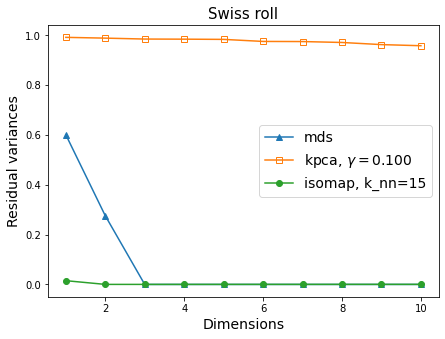

In [55]:
plt.figure(figsize=(7,5))
plt.plot(n_dimension, resVar_mds, marker="^",label="mds")
plt.plot(n_dimension, resVar_kpca, marker="s", mfc="None",label="kpca, $\gamma=%.3f$"%gamma)
plt.plot(n_dimension, resVar_isomap, marker="o", label="isomap, k_nn=%d"%k_opt, )
plt.legend(loc="best", prop={"size":14})
plt.ylabel("Residual variances", size=14)
plt.xlabel("Dimensions", size=14)
plt.title("Swiss roll", size=15)
plt.show()

# kernel PCA

In [5]:
def gaussRBF_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.        
    
    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_samples, n_features]      
    gamma: float        
    
    Tuning parameter of the RBF kernel        
    Number of principal components to return 
    n_components: int               
    
    Returns
    ------------
    Projected dataset       
    X_pc: {NumPy ndarray}, shape = [n_examples, k_features] 
    eig_vals_srtd: 
    """
    from sklearn.metrics.pairwise import euclidean_distances
    
    mat_sq_dists = euclidean_distances(X, squared=True)
    
    # Compute the symmetric kernel matrix.    
    K = np.exp(-gamma * mat_sq_dists)        

    # Center the kernel matrix.    
    N = K.shape[0]    
    one_n = np.ones((N,N)) / N    
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)        

    # Set the Kernel upto 8 decimal places
    K = np.around(K, decimals=8)

    # Check for symmetry
    #print("Is symmetric?", np.all(K==K.T))
    
    # 3. Compute eigenvectors and values of the kernel
    eig_vals , eig_vecs = np.linalg.eig( K )

    # 4. Sort and choose the first 3 largest eigenvectors
    srt = np.argsort( eig_vals )[:: -1]

    eig_vals_srtd = eig_vals[srt] # sorted eigenvalues
    eig_vecs_srtd = eig_vecs[:, srt]
    #n_components = 2


    # 5. Project to a low dimensional subspace d(=n_components)
    X_pc = eig_vecs_srtd [:,0:n_components]

    # 6. Scale the projected components
    X_pc = X_pc * np.sqrt(eig_vals_srtd[0:n_components])#np.diag( np.sqrt(eig_vals_srtd[0:n_components])) )

    return X_pc, eig_vals_srtd


In [41]:
# Variance explained with different parameters of gamma


gamma_vals = np.linspace(0.001, 0.05, 10)

n_components = 2
var_exp_list = []

for gamma in gamma_vals:
    _, eig_vals_srtd = gaussRBF_kernel_pca(X, gamma, n_components)
    
    total_var = eig_vals_srtd.sum()
    var_exp = np.array([(v / total_var)*100 for v in eig_vals_srtd])
    
    var_exp_list.append(var_exp)

var_exp_list = np.array(var_exp_list)

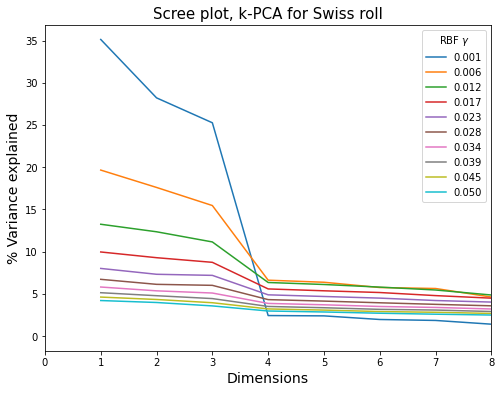

In [47]:
plt.figure(figsize=(8,6))
for i in range(len(gamma_vals)):
    ind = 50
    dim = range(1,ind+1)
    plt.plot(dim, var_exp_list[i, :ind], label="%.3f"%gamma_vals[i])
plt.xlim([0,8])
plt.xlabel("Dimensions", size=14)
plt.ylabel("% Variance explained", size=14)
plt.legend(title="RBF $\gamma$", loc="best")
plt.title("Scree plot, k-PCA for Swiss roll", size=15)
plt.show()

In [49]:
gamma=0.1
n_components = 2
X_pc, eig_vals_srtd = gaussRBF_kernel_pca(X, gamma, n_components)

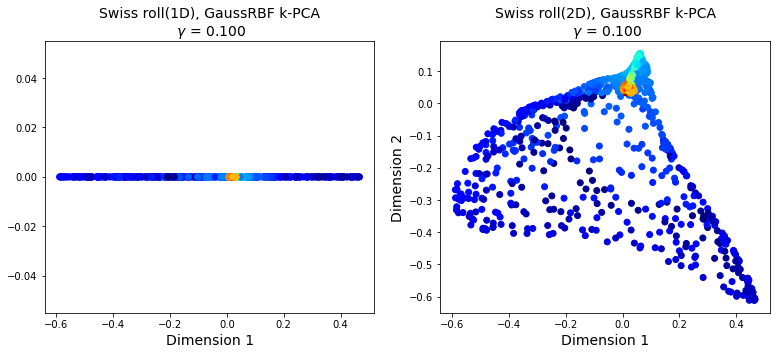

In [48]:
# the Swiss Roll, 2D 
fig = plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.scatter(X_pc[:, 0],np.zeros(X.shape[0]), c=t, cmap=plt.cm.jet)

plt.title('Swiss roll(1D), GaussRBF k-PCA\n $\gamma$ = %.3f'%gamma , size=14)
plt.xlabel('Dimension 1', size=14)

plt.subplot(1,2,2)
plt.scatter(X_pc[:, 0], X_pc[:, 1], c=t, cmap=plt.cm.jet)

plt.title('Swiss roll(2D), GaussRBF k-PCA\n $\gamma$ = %.3f'%gamma , size=14)
plt.xlabel('Dimension 1', size=14)
plt.ylabel('Dimension 2', size=14)

plt.show()

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA, KernelPCA

In [20]:
# Performance of k-PCA
gamma_vals = np.linspace(0.001, 0.04, 20)
kpca_mse = []

for gamma in gamma_vals:
    rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=gamma,fit_inverse_transform=True)
    X_reduced = rbf_pca.fit_transform(X)
    X_preimage = rbf_pca.inverse_transform(X_reduced)
    
    kpca_mse.append(mean_squared_error(X, X_preimage))


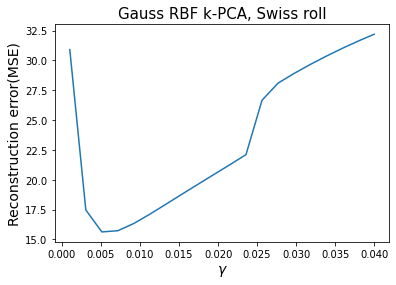

In [21]:
#plt.figure(figsize=(8,6))
plt.plot(gamma_vals, kpca_mse)
plt.xlabel("$\gamma$", size=14)
plt.ylabel("Reconstruction error(MSE)", size=14)
plt.title("Gauss RBF k-PCA, Swiss roll", size=15)
plt.show()

In [90]:
gamma_opt = gamma_vals[np.argmin(kpca_mse)]


In [92]:
n_components = 2
X_pc, eig_vals_srtd = gaussRBF_kernel_pca(X, gamma_opt, n_components)

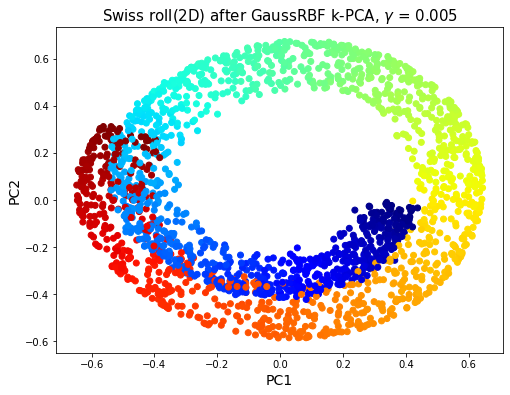

In [94]:
plt.figure(figsize=(8,6))
plt.scatter(X_pc[:, 0], X_pc[:, 1], c=t, cmap=plt.cm.jet)

plt.title('Swiss roll(2D) after GaussRBF k-PCA, $\gamma$ = %.3f'%gamma_opt, size=15)
plt.xlabel('PC1', size=14)
plt.ylabel('PC2', size=14)

plt.show()

In [ ]:
# Good linear seperation of the dataset


n_components = 2
gamma = 0.08

var_exp_list = []

fig, ax = plt.subplots(1,2, figsize=(11,5))
count=0
for gamma in gamma_vals:
    X_pc, eig_vals_srtd = gaussRBF_kernel_pca(X, gamma, n_components)
    
    ax[count].scatter(X_pc[:, 0], X_pc[:, 1], c=t, cmap=plt.cm.jet)

    ax[count].set_title('Swiss roll(2D), GaussRBF k-PCA, $\gamma$ = %.3f'%gamma, size=15)
    ax[count].set_xlabel('PC1', size=14)
    count+=1
ax[0].set_ylabel('PC2', size=14)
plt.show()



# ISOMAP

In [7]:
from sklearn.manifold import Isomap


In [11]:
k_nn = range(5,23)
error_list = []
for k in k_nn:
    isomap = Isomap(n_components=2, n_neighbors=k, path_method = "D", p=2)
    X_reduced_isomap = isomap.fit_transform(X)
    error_list.append(isomap.reconstruction_error())



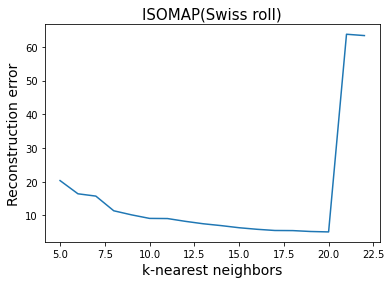

In [12]:
#plt.figure(figsize=(8,6))
plt.plot(k_nn, error_list)
plt.xlabel("k-nearest neighbors", size=14)
plt.ylabel("Reconstruction error", size=14)
plt.title("ISOMAP(Swiss roll)", size=15)
plt.show()


In [46]:
#k_opt = k_nn[np.argmin(error_list)]
k_opt = 15
isomap = Isomap(n_components=2, n_neighbors=k_opt, path_method = "D", p=2)
X_reduced_isomap = isomap.fit_transform(X)


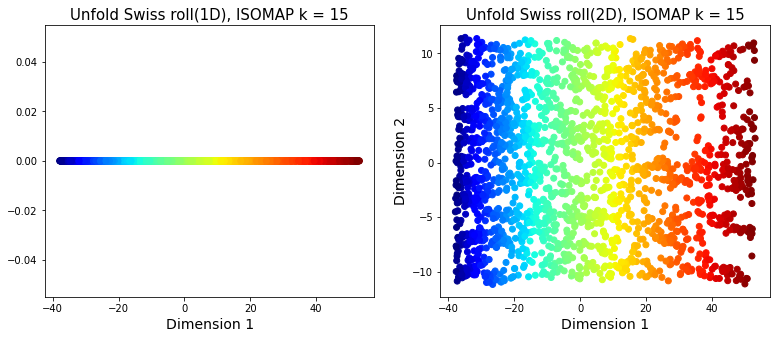

In [47]:
# the Swiss Roll, 2D 
fig = plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.scatter(X_reduced_isomap[:, 0], np.zeros(X.shape[0]), c=t, cmap=plt.cm.jet)

plt.title('Unfold Swiss roll(1D), ISOMAP k = %d'%k_opt, size=15)
plt.xlabel('Dimension 1', size=14)

plt.subplot(1,2,2)
plt.scatter(X_reduced_isomap[:, 0], X_reduced_isomap[:, 1], c=t, cmap=plt.cm.jet)
plt.title('Unfold Swiss roll(2D), ISOMAP k = %d'%k_opt, size=15)
plt.xlabel('Dimension 1', size=14)
plt.ylabel('Dimension 2', size=14)

plt.show()